In [1]:
# imports
import torch
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import scipy as sp
from classic_training import cost_func
from data import *
from generate_experiments import get_qnn
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib
import matplotlib as mpl
import qnns.cuda_qnn as cuda_qnn
from utils import *
from matplotlib import cm

In [2]:
# gen datapoints
def generate_random_datapoints(numb_points, s_rank, U):
    schmidt_rank = s_rank
    num_points = numb_points
    x_qbits = 1
    r_qbits = s_rank - x_qbits
    inputs = torch.from_numpy(
        np.array(uniform_random_data(schmidt_rank, num_points, x_qbits, r_qbits))
    )
    inputs = inputs.reshape(
        (inputs.shape[0], int(inputs.shape[1] / U.shape[0]), U.shape[0])
    ).permute(0, 2, 1)
    return inputs

In [3]:
# get zero/one datapoints
def get_zero_one_datapoints():
    zero_state = np.array([[1],[0]], dtype=complex)
    one_state = np.array([[0],[1]], dtype=complex)
    super_pos_state = np.array([[1],[1]], dtype=complex)/np.sqrt(2)
    tensor = torch.tensor([zero_state, one_state])
    return tensor
    # inputs = torch.from_numpy(np.array([zero_state, one_state], dtype=complex))
    # print(inputs.size())
    # inputs = inputs.reshape((inputs.shape[0], int(inputs.shape[1] / U.shape[0]), U.shape[0])).permute(0, 2, 1)
    # return inputs

In [4]:
# gen loss landscape
import math

def generate_loss_landscape(grid_size, inputs, U, qnn):
    landscape = []
    lanscape_limit = 2 * math.pi
    step_size = lanscape_limit / grid_size
    x = inputs
    expected_output = torch.matmul(U, x)
    y_true = expected_output.conj()
    for i in range(grid_size):
        # start at 2pi so y axis label still fits (upwards scaling instead of downards)
        arg_1 = lanscape_limit - i * step_size
        row = []
        for j in range(grid_size):
            # start at 0 because x axis label direction is correct
            arg_2 = j * step_size
            qnn.params = torch.tensor([[[arg_1, arg_2]]], dtype=torch.float64, requires_grad=True)
            cost = cost_func(inputs, y_true, qnn, device="cpu")
            row.append(cost.item())
        landscape.append(row)
    return landscape

In [5]:
# get plot metadata for different modes
def get_meta_for_mode(mode, data, min_val, max_val,titles,o, gate_name):
    low_threshold= 0.000000001
    if mode =="default":
        c_map ="plasma"
        sup_title= f"Loss Landscapes for U2($\\phi,\\lambda)$ Approximating {gate_name} for Different Datasets"
        title=titles[o]
        v_min = min(min_val, 0)
        v_max = max(max_val,1)
    elif mode == "grad":
        c_map ="winter"
        sup_title= "Gradient Magnitudes"
        # average gradient magnitude adjusted for sample frequency - not sure how to call this.
        title= f"GM Score: {np.round(np.average(data)*len(data), 2)}"
        v_min = min(min_val, 0)
        v_max = math.ceil(max_val * 100.0) / 100.0
    elif mode == "log_scale":
        v_max = 1
        #v_min = min((min_val+low_threshold/18)*12, low_threshold)
        v_min = low_threshold
        c_map ="Greys"
        if min_val < low_threshold:
            min_text="< 0.000000001"
        else:
            min_text=f"= {np.round(min_val, 10)}"        
        sup_title= f"Logarithmic Loss (min. {min_text})"
        title= titles[o]
    return c_map, sup_title, title, v_min, v_max

In [6]:
# plot a row of datasets
def plot_row(in_data,titles, gate_name, mode="default"):    
    in_data
    width = len(in_data)        
    min_val = np.min(in_data)
    max_val = np.max(in_data)
    fig, ax = plt.subplots(1, width, figsize=(9,3))
    for data_idx in range(width):        
        data = in_data[data_idx]
        # get mode dependent settings such as titles, color maps, thresholds, etc.
        c_map, sup_title, title, v_min, v_max = get_meta_for_mode(mode, data, min_val, max_val, titles, data_idx, gate_name)
        length = len(data)
        x_labels = []
        # create labels
        for i in range(length):
            n = f"{np.round(i*2/length, 1)} $\\pi$"
            x_labels.append(n)
        y_labels = reversed(x_labels)
        # do plot stuff
        # for logarithmic scale
        if mode == "log_scale":
            im = ax[data_idx].imshow(data, cmap = c_map,norm=matplotlib.colors.LogNorm(vmin=v_min, vmax=v_max))
        else:
        # normal scale
            im = ax[data_idx].imshow(data, cmap = c_map,vmin=v_min, vmax=v_max)
        # what happens to values below the color bar (=legend) threshold
        cm_copy= im.cmap.copy()
        cm_copy.set_under("r", 1)
        im.cmap = cm_copy
        # set label ticks
        ax[data_idx].set_xticks(np.arange(len(x_labels)), labels=x_labels)
        ax[data_idx].set_yticks(np.arange(len(x_labels)), labels=y_labels)
        ax[data_idx].set_ylabel("$\\phi$", rotation= 180, va="center")
        ax[data_idx].set_xlabel("$\\lambda$")
        tick_density = int(length / 4)
        # only display every x'th tick
        ax[data_idx].set_xticks(ax[data_idx].get_xticks()[::tick_density])
        ax[data_idx].set_yticks(ax[data_idx].get_yticks()[::tick_density])
        plt.setp(ax[data_idx].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        ax[data_idx].set_title(title)
    fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.58)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.75, 
                    top=0.9, 
                    wspace=0.7)
    fig.suptitle(sup_title, x=0.43)
    plt.show()

In [7]:
# plot 3D loss landscape
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def plot_3d_loss_landscape(landscape, title):
    ls = np.array(landscape)
    min_val = np.min(ls)
    max_val = np.max(ls)
    length = len(ls)
    x_labels = []
    # create labels
    for i in range(length):
        n = f"{np.round(i*2/length,1)} $\\pi$"
        x_labels.append(n)
    y_labels = reversed(x_labels)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    #im = ax.imshow(ls, cmap = "plasma",vmin=min(min_val, 0), vmax=max(max_val,1))
    X = np.arange(0, length,1)
    Y = np.arange(0, length,1)
    X, Y = np.meshgrid(X, Y)
    im = ax.plot_surface(X,Y,ls, cmap = "plasma",vmin=min(min_val, 0), vmax=max(max_val,1))
    # set label ticks
    ax.set_xticks(np.arange(len(x_labels)), labels=x_labels)
    ax.set_yticks(np.arange(len(x_labels)), labels=y_labels)
    ax.set_ylabel("$\\phi$", rotation= 180, va="center")
    ax.set_xlabel("$\\lambda$")
    ax.set_zlabel("Loss")
    tick_density = int(length / 10)
    # only display every x'th tick
    ax.set_xticks(ax.get_xticks()[::tick_density])
    ax.set_yticks(ax.get_yticks()[::tick_density])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Loss", rotation=-90, va="bottom")
    ax.set_title(f"U2($\\phi,\\lambda)$ Approximating {title}")
    plt.show()

In [8]:
# get grad curvature
def get_grad_curv(landscape):
    first_order_gradients = np.gradient(np.array(landscape))
    second_order_gradients = []
    for grad in first_order_gradients:
        grads_of_grad = np.gradient(np.array(grad))
        for sec_grad in grads_of_grad:
            second_order_gradients.append(sec_grad)
    magnitude_sum = 0
    for g in second_order_gradients:
        magnitude_sum += g**2
    curv_mag = np.sqrt(magnitude_sum)
    return curv_mag

In [9]:
# get scalar curvature
def get_scalar_curvature(landscape):
    gradients = np.array(np.gradient(np.array(landscape)))
    scalar_curvature = np.zeros(gradients[0].shape)
    # maybe add gradients? not sure
    for gradient in gradients:
        hessians = np.array(np.gradient(np.array(gradient)))
        for hessian in hessians:
            gradient = np.array(gradient)
            # take euclidean norm
            beta = 1/(1+np.linalg.norm(gradient)**2)
            hessian = np.array(hessian)
            #print("beta: ", beta)
            # print("hessian: ", hessian.shape)
            # print("trace(hessian): ", np.trace(hessian))
            # print("grad: ", gradient.shape)
            left_term = np.trace(hessian)**2-np.trace(np.matmul(hessian, hessian))
            right_term= np.matmul(2*(beta**2)*(gradient.T*(np.matmul(hessian, hessian)-np.trace(hessian)*hessian)),gradient)
            scalar_curvature += beta*(left_term + right_term)    
    return scalar_curvature

In [10]:
# plot 3D loss landscape with curvature coloring
def plot_3d_loss_landscape_curv(landscape, curv_mode = "scalar"):
    ls = np.array(landscape)
    if curv_mode == "scalar":        
        curv = get_scalar_curvature(landscape)
    elif curv_mode == "grad":
        curv = get_grad_curv(landscape)
    min_val = np.min(curv)
    max_val = np.max(curv)
    length = len(curv)
    x_labels = []
    # create labels
    for i in range(length):
        n = f"{np.round(i*2/length,1)} $\\pi$"
        x_labels.append(n)
    y_labels = reversed(x_labels)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    X = np.arange(0, length,1)
    Y = np.arange(0, length,1)
    X, Y = np.meshgrid(X, Y)
    norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
    c_map = mpl.cm.plasma
    im = ax.plot_surface(X,Y,ls, cmap = c_map, facecolors = c_map(norm(curv)))
    # set label ticks
    ax.set_xticks(np.arange(len(x_labels)), labels=x_labels)
    ax.set_yticks(np.arange(len(x_labels)), labels=y_labels)
    ax.set_ylabel("$\\phi$", rotation= 180, va="center")
    ax.set_xlabel("$\\lambda$")
    ax.set_zlabel("Loss")
    tick_density = int(length / 10)
    # only display every x'th tick
    ax.set_xticks(ax.get_xticks()[::tick_density])
    ax.set_yticks(ax.get_yticks()[::tick_density])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #cbar = ax.figure.colorbar(im, ax=ax)
    #cbar.ax.set_ylabel("Loss", rotation=-90, va="bottom")
    m = cm.ScalarMappable(cmap=c_map, norm=norm)
    m.set_array([])
    plt.colorbar(m)
    ax.set_title(f"U2($\\phi,\\lambda)$ Curvature - {curv_mode} curvature")
    plt.show()

In [11]:
# calculate Total Variation
def calc_total_variation(landscape):
    lanscape_limit = 2 * math.pi
    step_size = lanscape_limit / len(landscape)
    gradients = np.gradient(np.array(landscape))
    total_variation = np.sum(np.absolute(gradients))
    # normalize by adjusting for step size
    normalized_tv = total_variation*step_size
    return np.round(normalized_tv,2)

In [12]:
# calculate IGSD
def calc_IGSD(landscape):
    gradients = np.gradient(np.array(landscape))
    # each array of the gradients encompasses the gradients for one dimension/direction/parameter
    gradient_standard_deviations = []
    for gradient in gradients:
        gradient_standard_deviations.append(np.std(gradient))
    inverse_gradient_standard_deviations= np.divide(1,gradient_standard_deviations)
    return np.round(inverse_gradient_standard_deviations,2)

In [13]:
# multi plot with gradients
def multi_plot_landscape(landscapes, titles, gate_name): 
    data = np.array(landscapes)
    # calculate gradient magnitudes
    gradient_magnitudes=[]
    for landscape_idx in range(len(data)):
        gradient = np.gradient(np.array(landscapes[landscape_idx]))
        grad_mag = np.sqrt(gradient[0]**2+gradient[1]**2)
        gradient_magnitudes.append(grad_mag)
    # Plot rows for each mode you want to display
    plot_row(data, titles,gate_name, mode="default")
    plot_row(data, titles,gate_name, mode="log_scale")
    plot_row(gradient_magnitudes, titles, gate_name, mode="grad")

In [14]:
# print expected output
def print_expected_output(U, x, name):
    print("====")
    expected_output = torch.matmul(U,x)
    np_arr = expected_output.detach().cpu().numpy()
    print("expected output for ",name,":\n",np_arr)
    print("====")

In [15]:
# print datapoints
def print_datapoints(points, title):
    print("", title, " data points:")
    np_arr = points.detach().cpu().numpy()
    for i, row in enumerate(np_arr):
        print("---")
        for j, point in enumerate(row):
            #idx = i * len(row) + j + 1
            print("",i," - ", j, ":", point)
        

In [16]:
# Experiments Framework
def run_experiment_on(gate_name, Unitary, print_info = True, num_data_points=1, num_ticks = 40):
    qnn = get_qnn("CudaU2", list(range(1)), 1, device="cpu")
    # generate data points
    non_entangled_inputs = generate_random_datapoints(num_data_points, 1, Unitary)
    entangled_inputs = generate_random_datapoints(num_data_points,2,Unitary)
    z_o_inputs = get_zero_one_datapoints()
    if print_info:
        # print data points
        print_datapoints(z_o_inputs, "zero-one")
        print_datapoints(non_entangled_inputs, "not entangled")
        print_datapoints(entangled_inputs, "entangled")
        #print expected output
        print_expected_output(Unitary, z_o_inputs, "zero one")
    # calculate loss landscapes
    loss_z_o = generate_loss_landscape(num_ticks, z_o_inputs, Unitary, qnn)
    loss_non_ent = generate_loss_landscape(num_ticks, non_entangled_inputs, Unitary, qnn)
    loss_ent = generate_loss_landscape(num_ticks, entangled_inputs, Unitary, qnn)
    # multiplot lanscapes and gradients    
    landscapes = [loss_z_o,loss_non_ent, loss_ent]
    names = [f"Zero-One, n = 2",f"Not Entangled, n = {num_data_points}", f"Entangled, n = {num_data_points}"]
    multi_plot_landscape(landscapes, names, gate_name)
    # print advanced metrics    
    print("TOTAL VARIATION: ",calc_total_variation(landscapes[0]),calc_total_variation(landscapes[1]),calc_total_variation(landscapes[2]))
    for landscape in landscapes:
        igsd = calc_IGSD(landscape)
        print("IGSD (dir 1): ", igsd[0])
        print("IGSD (dir 2): ", igsd[1])
        print("---------")
    # plot loss landscapes
    plot_3d_loss_landscape(loss_z_o, f"{gate_name} (Zero-One, n = 2)")
    plot_3d_loss_landscape(loss_non_ent, f"{gate_name} (Not Entangled, n = {num_data_points})")
    plot_3d_loss_landscape(loss_ent, f"{gate_name} (Entangled, n = {num_data_points})")
    # with curvature coloring placeholder
    plot_3d_loss_landscape_curv(loss_z_o, "scalar")
    plot_3d_loss_landscape_curv(loss_z_o, "grad")
    plot_3d_loss_landscape_curv(loss_non_ent, "scalar")
    plot_3d_loss_landscape_curv(loss_non_ent, "grad")
    plot_3d_loss_landscape_curv(loss_ent, "scalar")
    plot_3d_loss_landscape_curv(loss_ent, "grad")

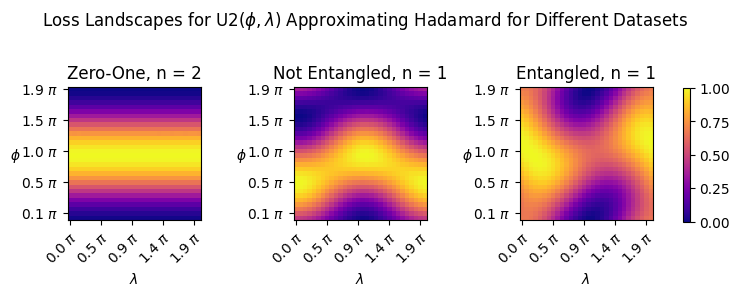

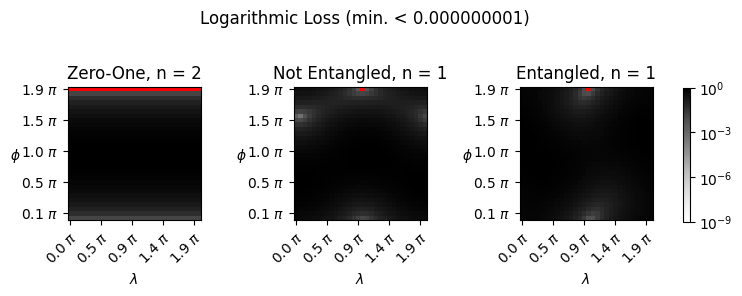

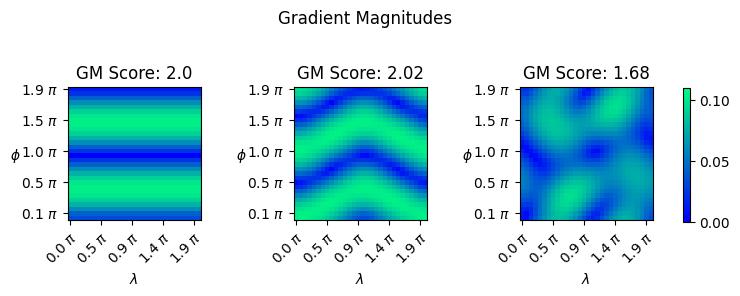

TOTAL VARIATION:  12.56 16.06 14.07
IGSD (dir 1):  13.57
IGSD (dir 2):  1.5261325396730768e+16
---------
IGSD (dir 1):  15.04
IGSD (dir 2):  31.92
---------
IGSD (dir 1):  24.77
IGSD (dir 2):  22.71
---------


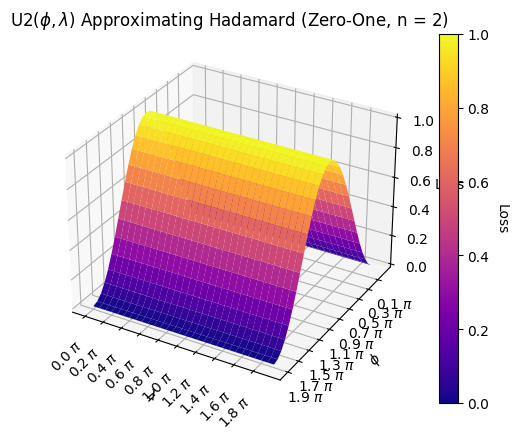

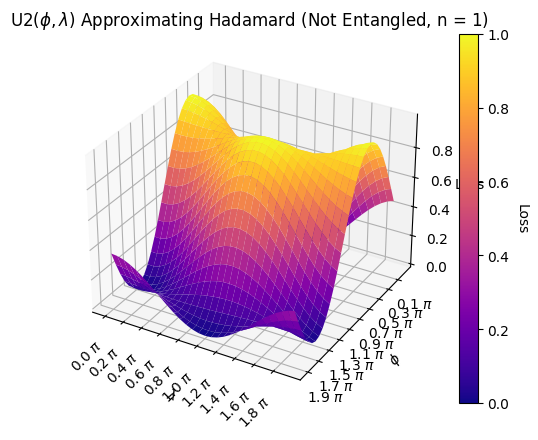

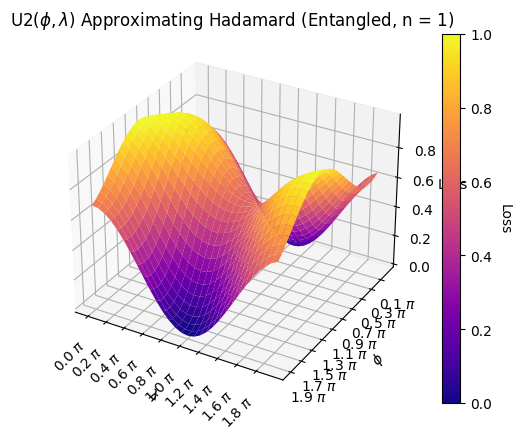

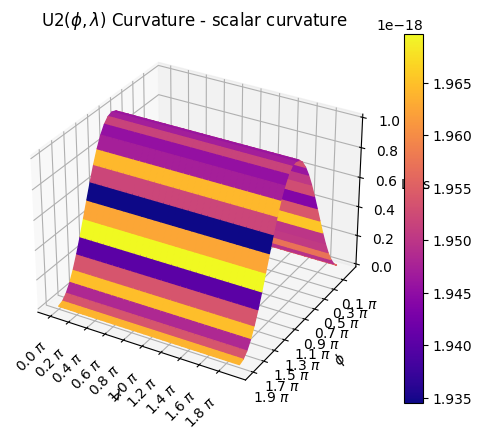

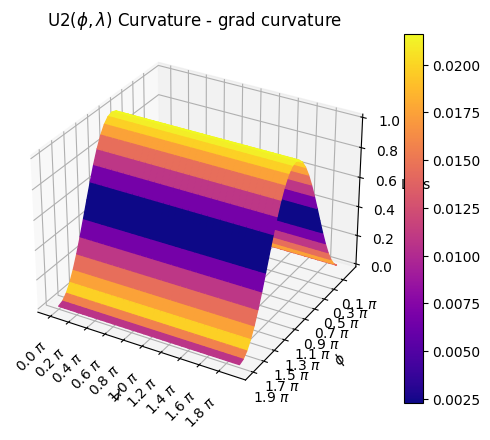

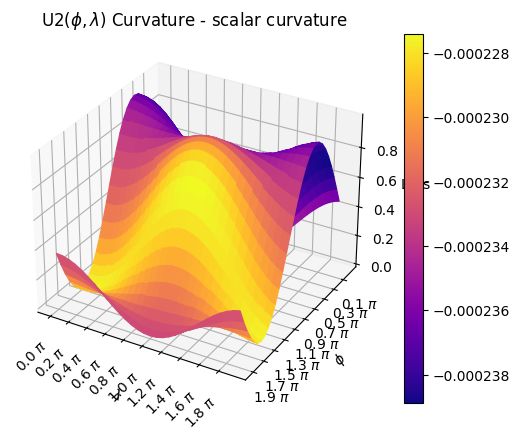

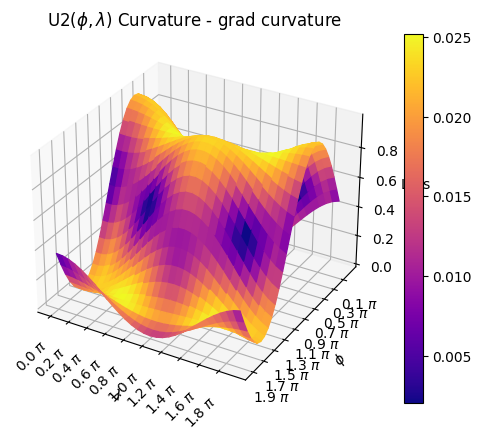

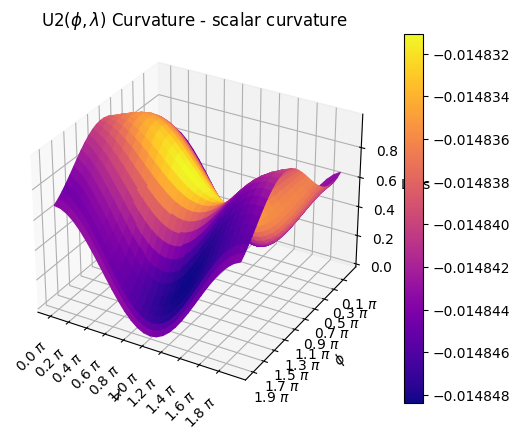

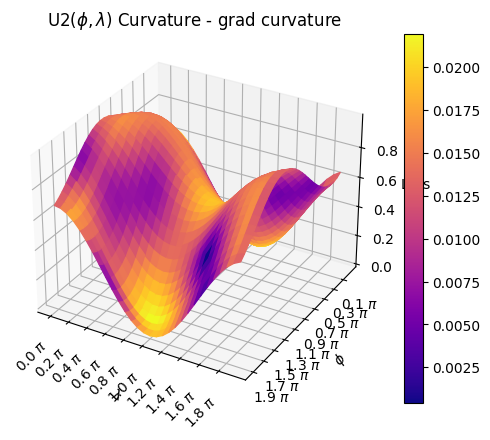

In [29]:
# EXP on Hadamard
U = torch.tensor(np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu")
run_experiment_on("Hadamard", U, print_info=False, num_data_points=1, num_ticks = 30)
# red dots on logarithmic loss are true minima (below a certain threshold), sometimes they are just above the threshold but still true minima (due to sampling) and they will appear white (not grey, as grey means they are false minima)
# if num_ticks is too large you cant see the red dots anymore (maybe due to aliasing?)

 zero-one  data points:
---
 0  -  0 : [1.+0.j]
 0  -  1 : [0.+0.j]
---
 1  -  0 : [0.+0.j]
 1  -  1 : [1.+0.j]
 not entangled  data points:
---
 0  -  0 : [-0.35892111-0.49040059j]
 0  -  1 : [-0.78573395-0.11534754j]
 entangled  data points:
---
 0  -  0 : [-0.4888174 -0.49397828j -0.25180811-0.44059233j]
 0  -  1 : [-0.23256193-0.22747146j  0.32088433+0.22520881j]
====
expected output for  zero one :
 [[[0.+0.j]
  [1.+0.j]]

 [[1.+0.j]
  [0.+0.j]]]
====


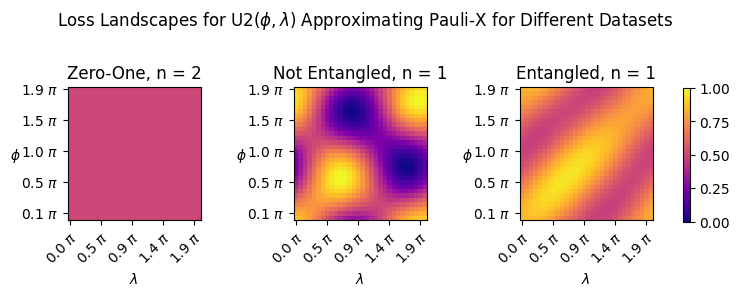

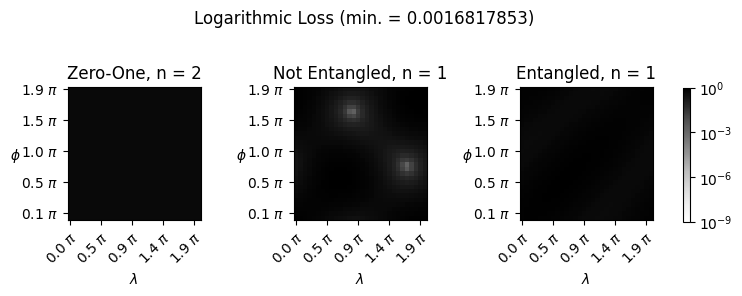

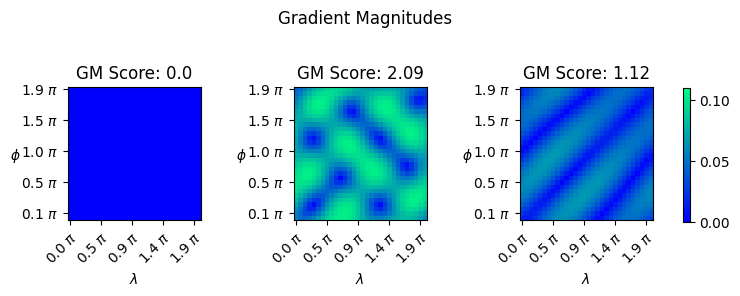

TOTAL VARIATION:  0.0 16.51 9.73
IGSD (dir 1):  2.196329502338442e+16
IGSD (dir 2):  2.3050057191290612e+16
---------
IGSD (dir 1):  19.28
IGSD (dir 2):  19.27
---------
IGSD (dir 1):  34.42
IGSD (dir 2):  34.43
---------


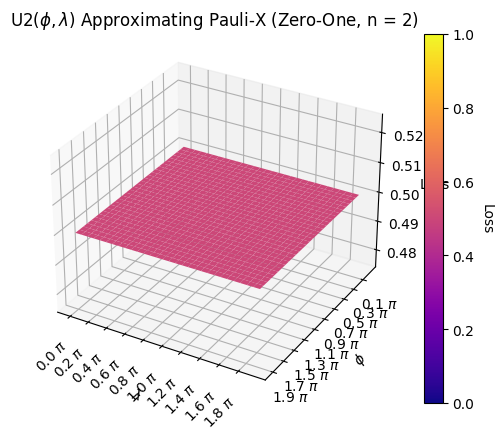

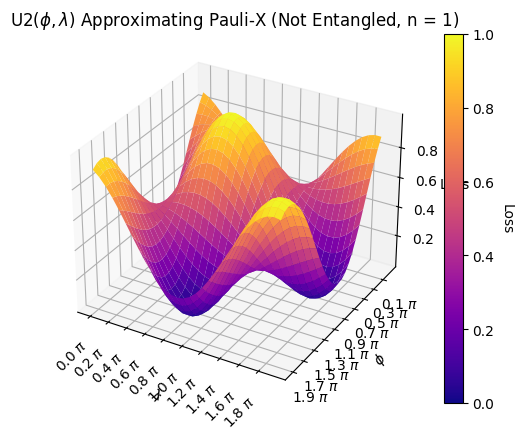

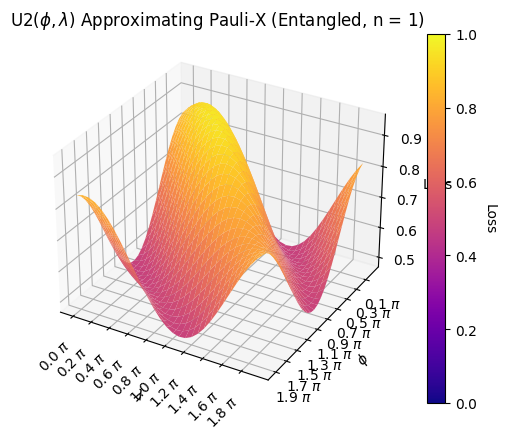

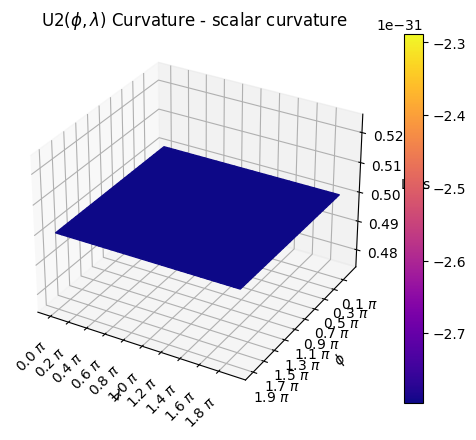

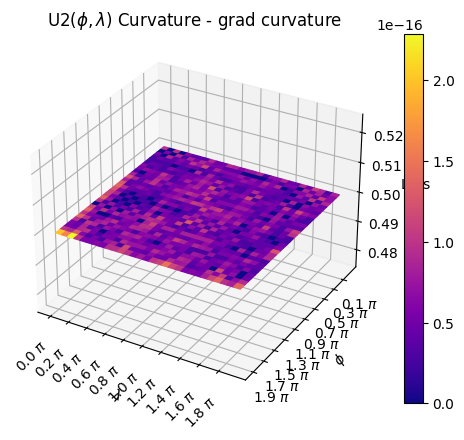

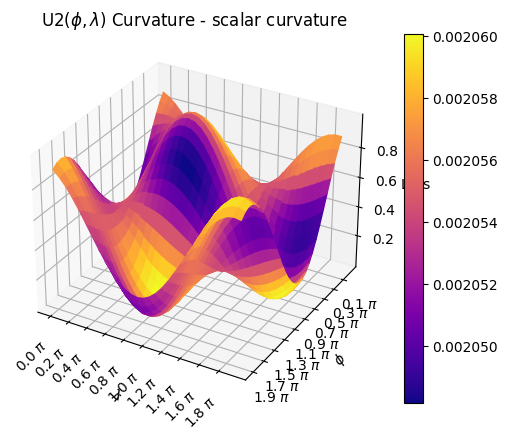

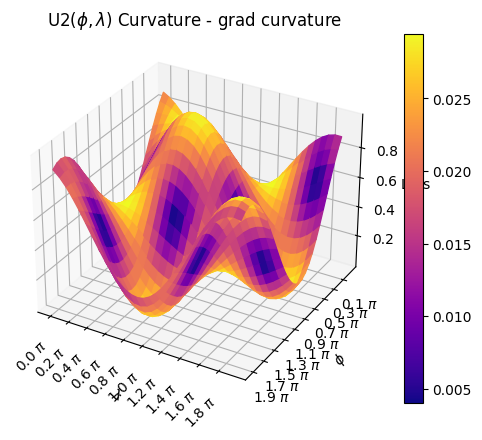

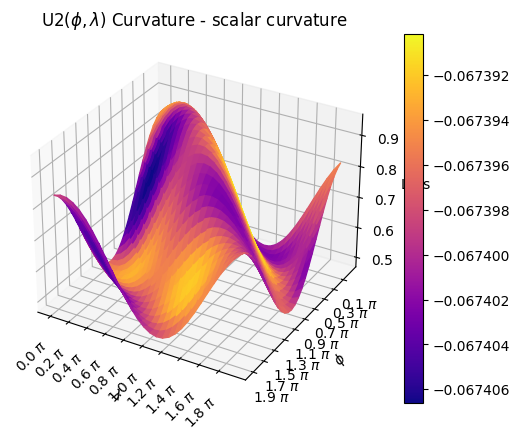

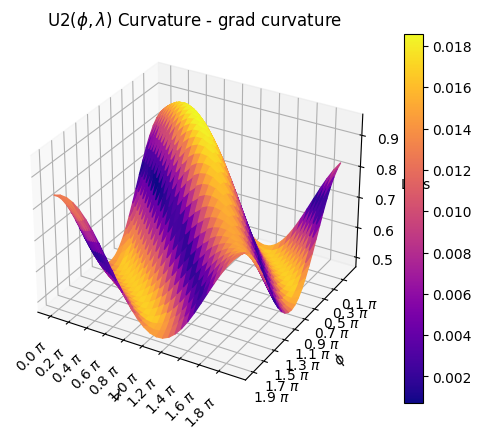

In [24]:
# EXP on Pauli-X
U = torch.tensor(np.array([[0, 1], [1, 0]]), dtype=torch.complex128, device="cpu")
run_experiment_on("Pauli-X", U, print_info=True, num_data_points=1, num_ticks = 30)

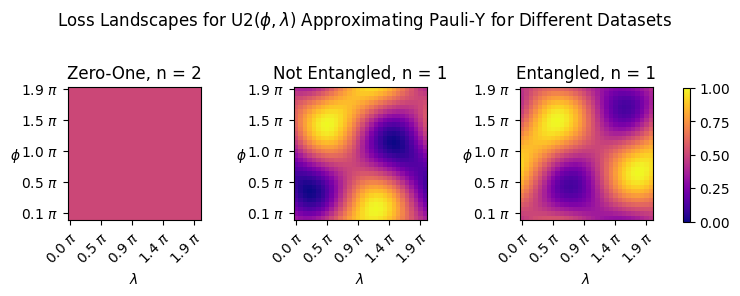

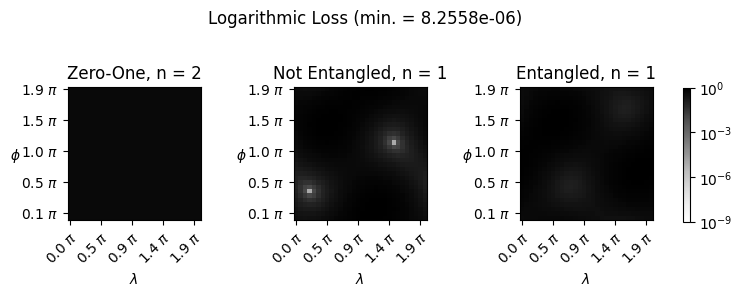

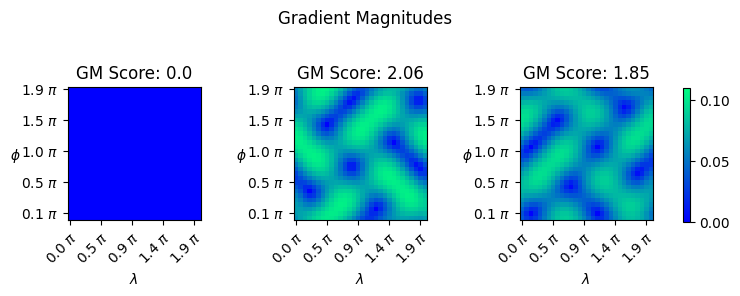

TOTAL VARIATION:  0.0 16.72 14.79
IGSD (dir 1):  2.196329502338442e+16
IGSD (dir 2):  2.3050057191290612e+16
---------
IGSD (dir 1):  19.44
IGSD (dir 2):  19.44
---------
IGSD (dir 1):  21.65
IGSD (dir 2):  21.64
---------


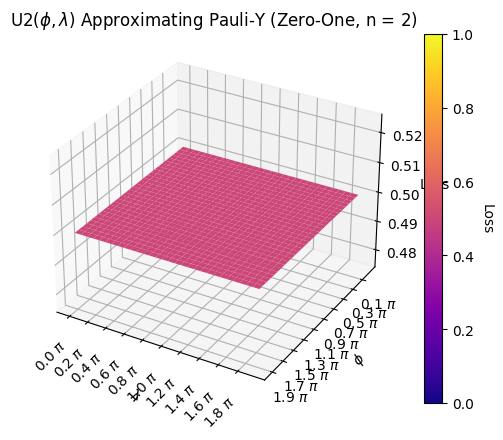

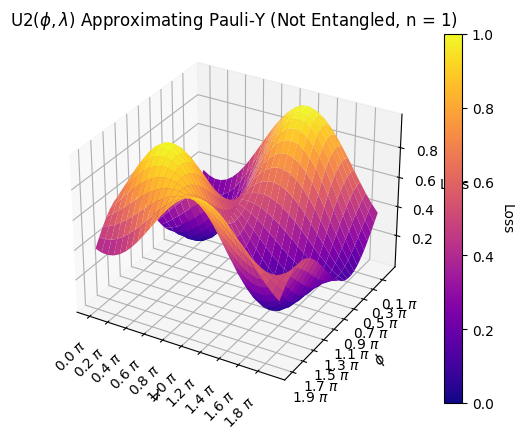

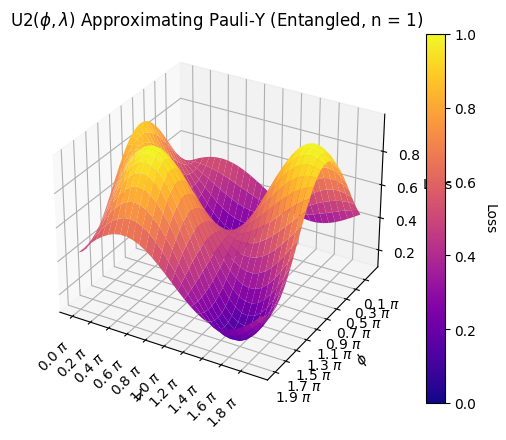

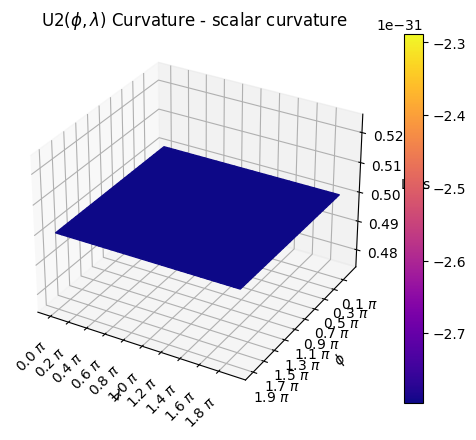

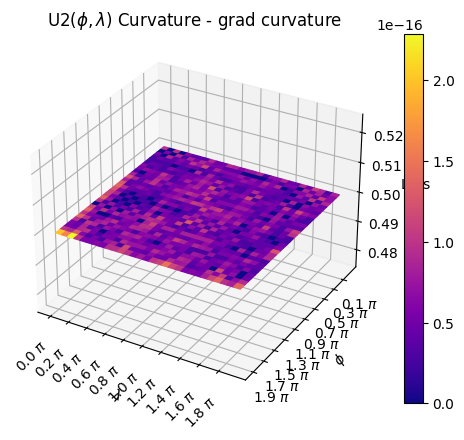

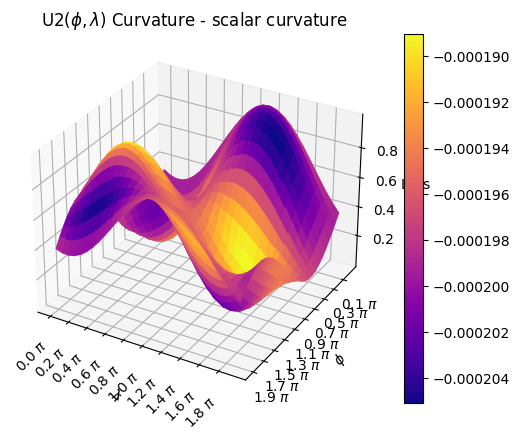

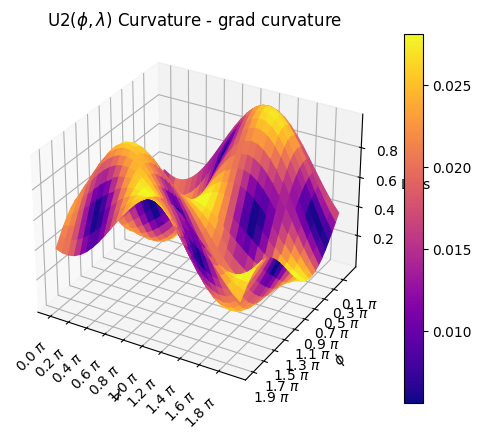

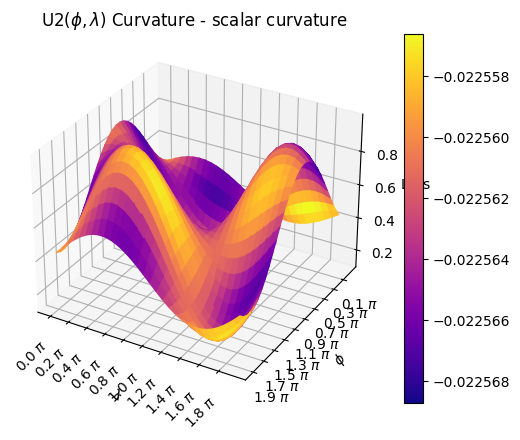

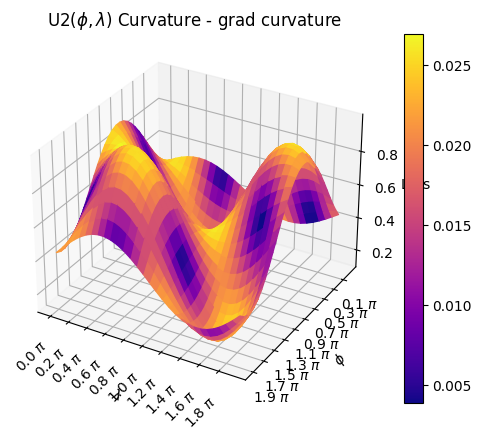

In [19]:
# EXP on Pauli-Y
U = torch.tensor(np.array([[0, -1j], [1j, 0]]), dtype=torch.complex128, device="cpu")
run_experiment_on("Pauli-Y", U, print_info=False, num_data_points=1, num_ticks = 30)

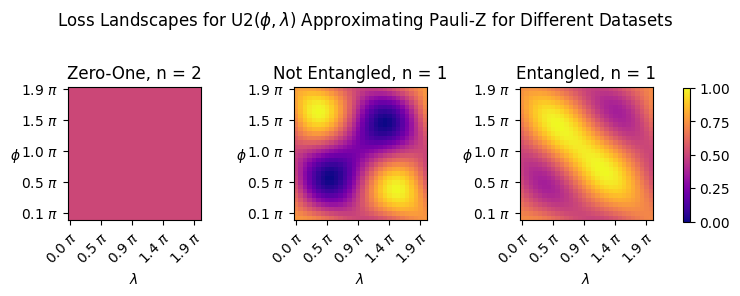

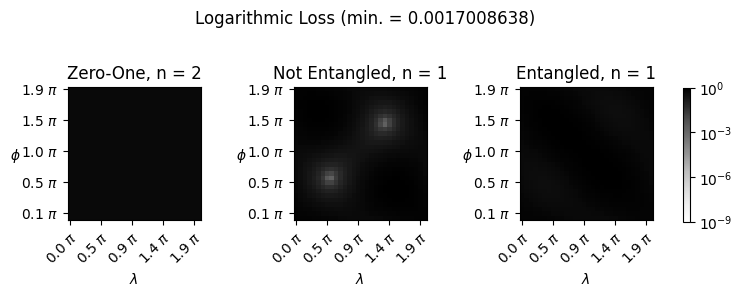

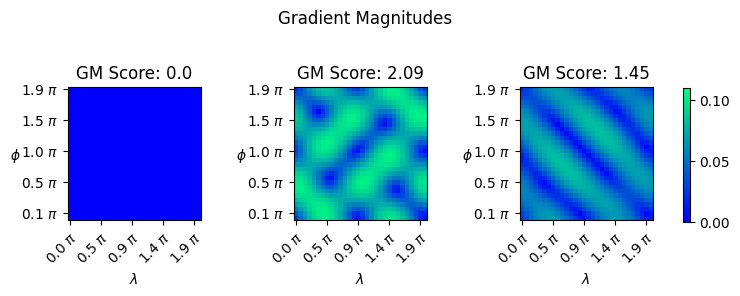

TOTAL VARIATION:  0.0 16.51 12.16
IGSD (dir 1):  1.856957136330167e+16
IGSD (dir 2):  1.857005858674263e+16
---------
IGSD (dir 1):  19.3
IGSD (dir 2):  19.3
---------
IGSD (dir 1):  27.08
IGSD (dir 2):  27.08
---------


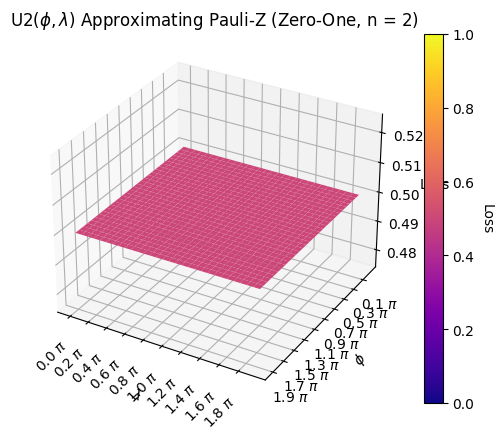

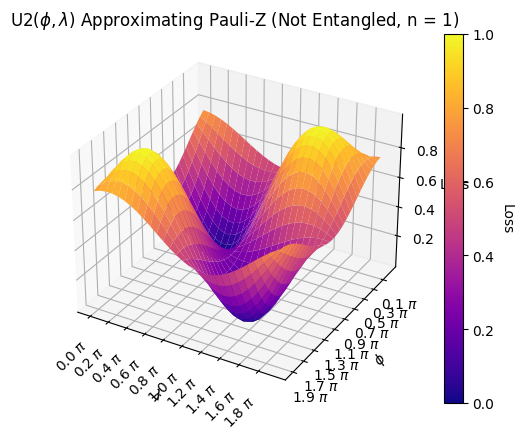

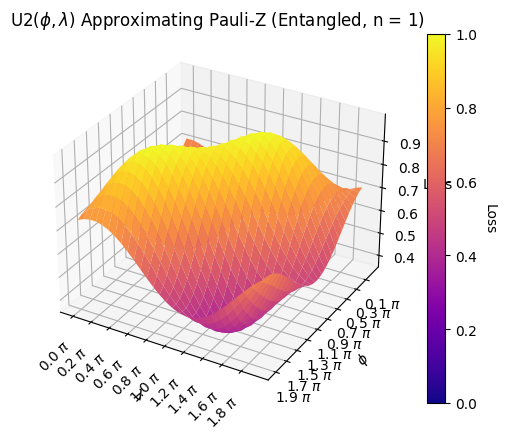

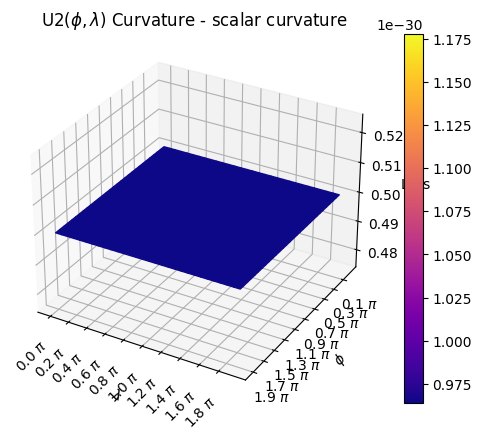

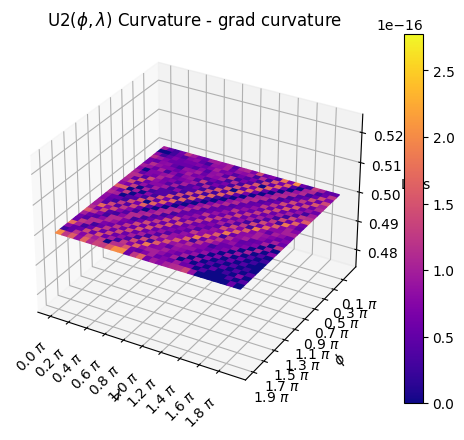

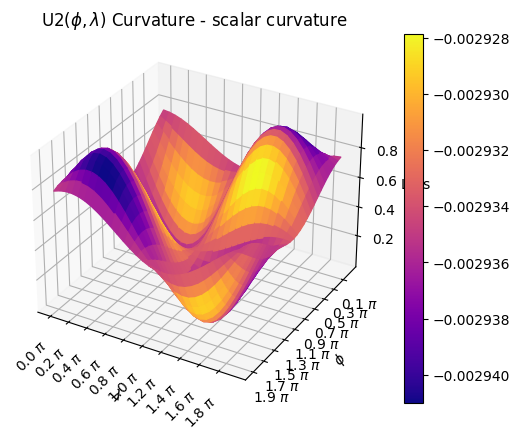

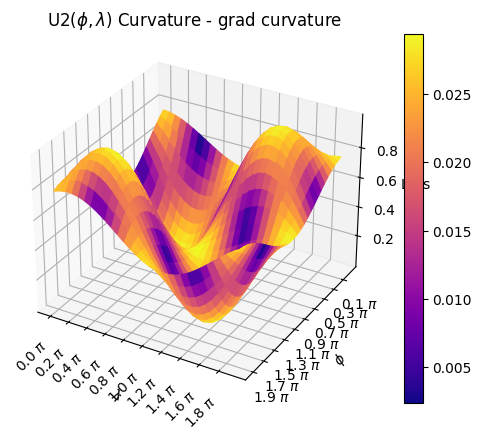

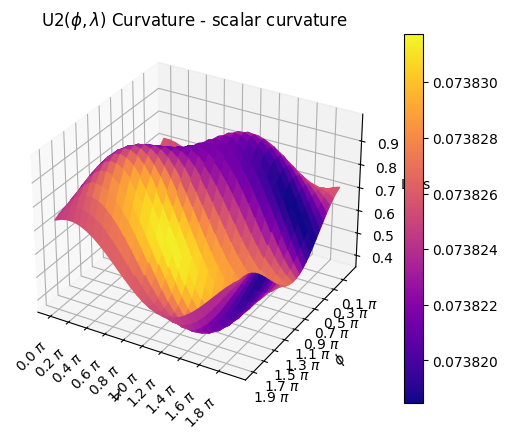

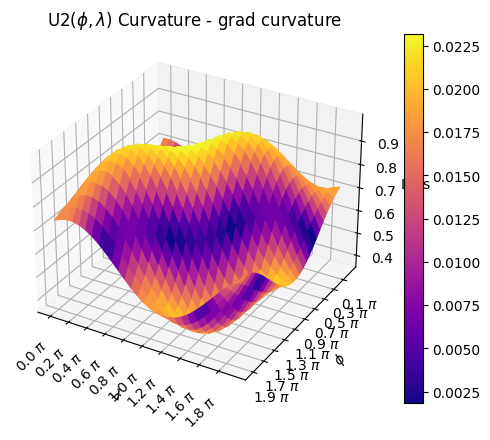

In [26]:
# EXP on Pauli-Z
U = torch.tensor(np.array([[1, 0], [0, -1]]), dtype=torch.complex128, device="cpu")
run_experiment_on("Pauli-Z", U, print_info=False, num_data_points=1, num_ticks = 30)

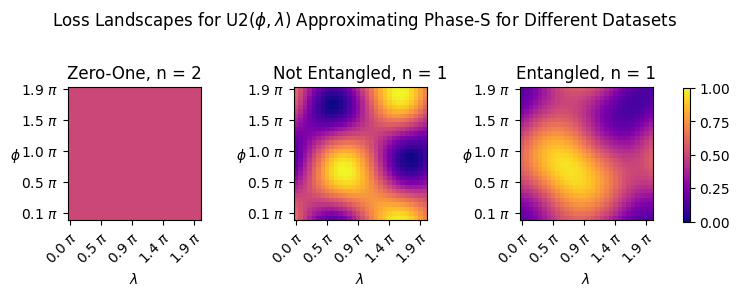

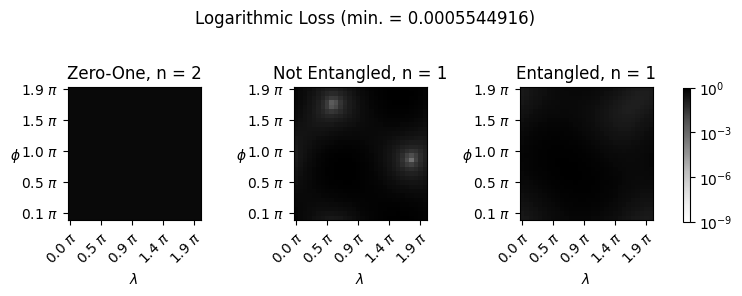

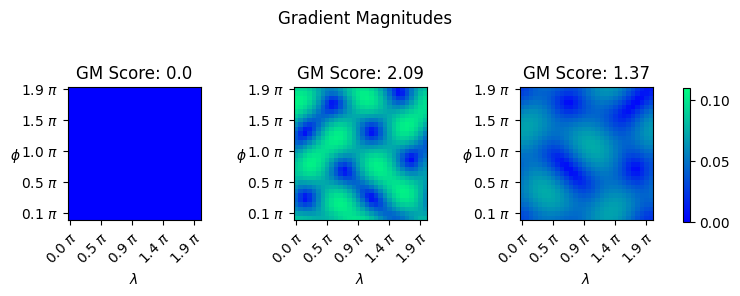

TOTAL VARIATION:  0.0 16.51 11.56
IGSD (dir 1):  2.1899427947809236e+16
IGSD (dir 2):  2.197218785834663e+16
---------
IGSD (dir 1):  19.26
IGSD (dir 2):  19.29
---------
IGSD (dir 1):  29.25
IGSD (dir 2):  29.25
---------


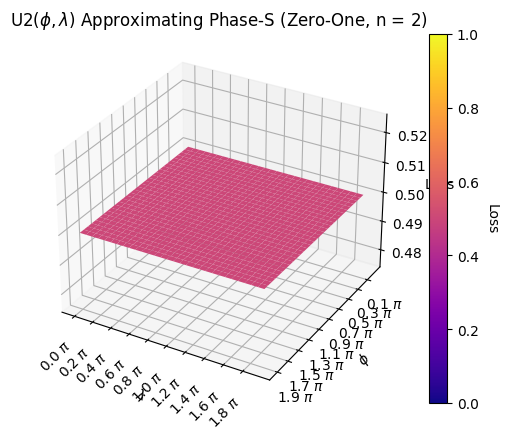

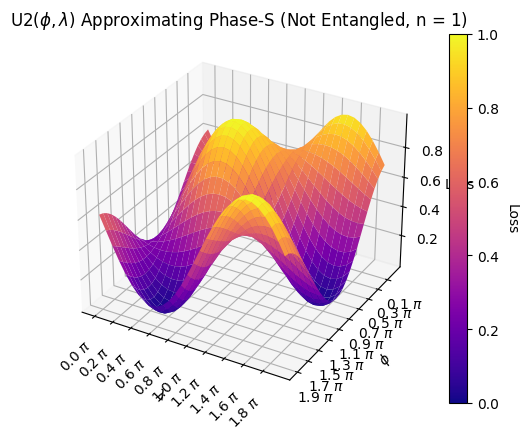

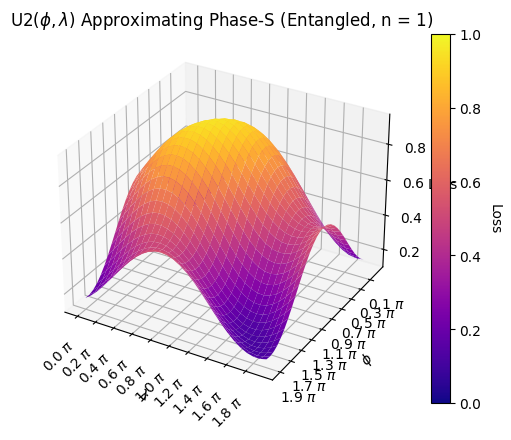

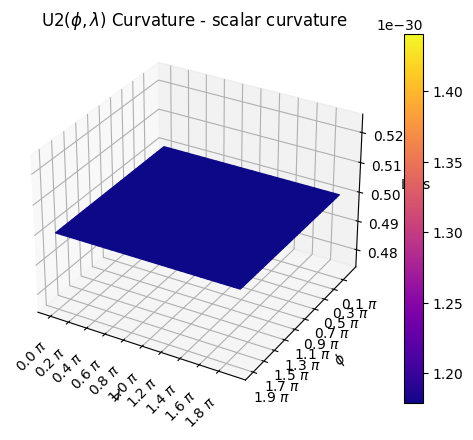

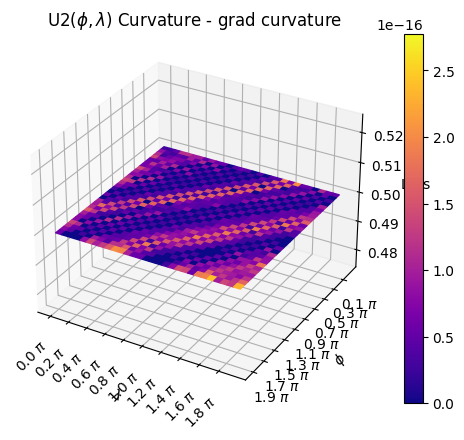

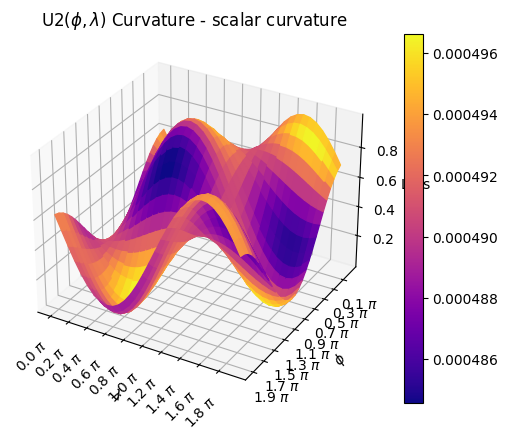

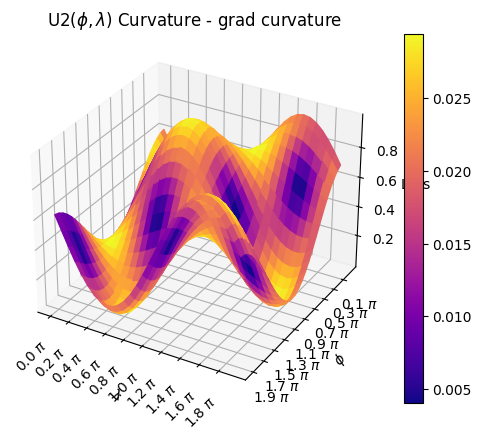

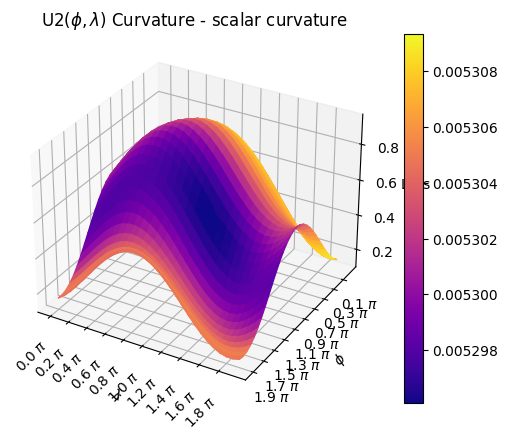

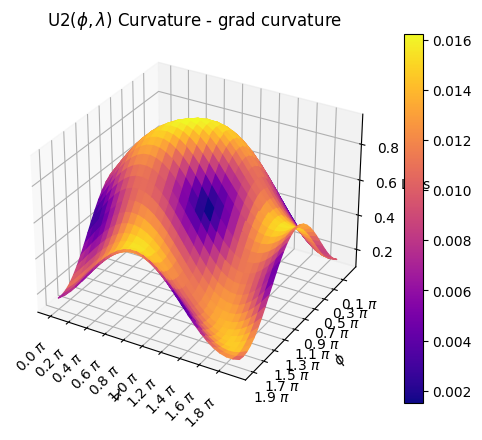

In [28]:
# EXP on Phase (S)
U = torch.tensor(np.array([[1, 0], [0, 1j]]), dtype=torch.complex128, device="cpu")
run_experiment_on("Phase-S", U, print_info=False, num_data_points=1, num_ticks = 30)